# Predicting class labels using Node2Vec

In [1]:
import numpy as np
import pandas as pd

from lib.DataSet import DataSet
from matplotlib import pyplot as plt

## Introduction

This report explores the effect of different parameter values on the performance of the [Node2Vec algorithm](https://snap.stanford.edu/node2vec/).

## Data

### Introduction

The original multilabel classification data from the [Node2Vec paper](https://arxiv.org/abs/1607.00653) were used, from which 2 datasets were selected.

Both datasets consist of a `network` (an adjacency matrix) and a `group` (the set of labels for each node id).

In [2]:
hosap_data = DataSet('./data/Homo_sapiens.mat')
pos_data = DataSet('./data/POS.mat')

#### [Protein-Protein interactions dataset](https://downloads.thebiogrid.org/BioGRID)

This dataset contains data on protein-protein interactions for Homo Sapiens. Each label describes a biological state of a protein involved in such interactions. Links and nodes are both unweighted.

The labels in the dataset are well distributed, with sufficient number to both train and test a classifier.

[]

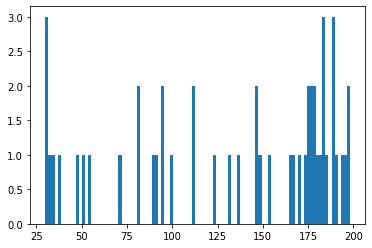

In [3]:
sums = np.sum(hosap_data.group, axis=0)
plt.hist(sums, bins=100)
plt.plot()

In [4]:
category_sizes = np.sum(hosap_data.group, axis=0)
category_sizes

array([ 33,  51, 180, 176,  94, 194, 166, 178, 182, 188, 170,  31, 189,
       177,  47, 185,  90,  81, 167, 137, 111,  71, 189, 148,  30, 197,
       146, 183,  82, 112, 190, 176,  55, 198, 183,  92, 132, 154,  94,
       177, 184, 179, 100, 195,  34, 173,  37, 147, 124,  31])

In [5]:
max_category_size = np.amax(category_sizes)
hosap_data.group[:,33]

array([0, 0, 0, ..., 0, 1, 0])

In [6]:
max_category_index = np.where(category_sizes == max_category_size)
max_category_index[0]

array([33])

In [51]:
# def retain_largest_category(dataset_labels):
#     label_sizes = np.sum(dataset_labels, axis=0)
#     biggest_label_size = np.amax(label_sizes)
#     biggest_label_index = np.where(label_sizes == biggest_label_size)[0]
#
#     return (dataset_labels[:,biggest_label_index], biggest_label_index)
#
# np.sum(retain_largest_category(hosap_data.group)[0])

198.0

What is the size of largest category in the PPI dataset?

In [52]:
from lib.ProjectGraph import retain_largest_category

(hosap_labels, hosap_index) = retain_largest_category(hosap_data.group)
np.sum(hosap_labels)

198.0

In [53]:
hosap_labels

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])

What category to investigate on the Wikipedia dataset?

In [8]:
from igraph import Graph
from lib.ProjectGraph import init_igraph

graph: Graph = init_igraph(hosap_data, only_largest_component=True)
graph.summary()

2022-05-19 12:36:33.532508: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'IGRAPH D--- 3852 76546 -- \n+ attr: labels (v)'

'IGRAPH D--- 3852 76546 -- \n+ attr: labels (v)'

Retain only the labels for the largest category:

In [11]:
from lib.ProjectGraph import retain_largest_category

labels, graph = retain_largest_category(graph)
graph.summary()

'IGRAPH D--- 3852 76546 -- \n+ attr: category (v), labels (v)'

In [13]:
# graph.vs.get_attribute_values("category")

In [14]:
# (pos_labels, pos_index) = retain_largest_category(pos_data.group)
# np.sum(pos_labels)

In [15]:
# pos_labels

#### [Wikipedia POS dataset](http://www.mattmahoney.net/dc/textdata)

This dataset contains data on POS tags for words in wikipedia articles. The edges represent co-occurrences of these words. Based on co-occurrence patterns of words, POS labels are predicted. The nodes are weighed, the edges are not. In the classification task, we ignore the weights though.

One difficulty in this dataset is the label distribution, with most of the labels only occurring a few times. This leads to test sets with too few labels if we don't account for this.

[]

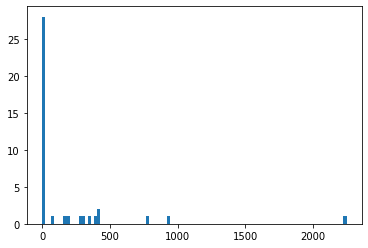

In [4]:
sums = np.sum(pos_data.group, axis=0)
plt.hist(sums, bins=100)
plt.plot()

## Method: Node2Vec

Node2Vec is an unsupervised transductive machine learning algorithm to learn feature representation for nodes in a network. To achieve this, first a dataset of node sequences is collected by a biased random walker. Viewing the node id's encountered in random walks as the words in a sentence, Word2Vec is then used to produce feature embeddings encoding a node's context. Armed with these embeddings, a classifier can use them to predict node properties. Alternatively, edge properties might be predicted if node embeddings can first be converted to edge embeddings.

### Biased Random Walker

#### Motivation

From the previous, it follows that the Word2Vec algorithm needs a representation of the context of node. Two simple neighborhood sampling strategies are DFS (depth-first) and BFS (breadth-first).

A DFS approach can explore large parts of the network, providing a macro view of the neighborhood, inferring communities based on _homophily_ when nodes are highly interconnected and belong to similar communities. Not a lot of nodes tend to repeat in walks DFS, so variance of a characterization is high.

A BFS approach restricts exploration to the immediate neighborhood of a node, providing a microscopic view with low characterization variance as lots of nodes tend to repeat in our sampling. Such an approach can identify _structural equivalence_ based on network roles (bridges, hubs, ...).

The Node2Vec paper identifies limitations in both these approaches and points out their rigidity. Node2Vec proposes to create a flexible approach that can tune the DFS and BFS bias of the random walker so that this bias can be customized towards a specific case.

#### Implementation

The random walk will be a $2^{nd}$ order random walk, parameterized with $p$ and $q$. For a random walk that just traversed edge $(t, v)$ and currently residing at node $v$, we need to calculate a transition probability $\pi_{vx}$ on edges $(v, x)$ leading from $v$. The unnormalized transition probability is set as $\pi_{v x}=\alpha_{p q}(t, x) \cdot w_{v x}$, with the search Bias $\alpha$ taking values as follows:

$$
\alpha_{p q}(t, x)=\left\{\begin{array}{ll}
\frac{1}{p} & \text { if } d_{t x}=0 \\
1 & \text { if } d_{t x}=1 \\
\frac{1}{q} & \text { if } d_{t x}=2
\end{array}\right.
$$

After walking from $t$ to $v$ to $x$, $d_{tx}$ represents the shortest path between $t$ and $x$. Intuitively, this means that $p$ and $q$ encode both the speed with which the walker explores and how easily it leaves the neighborhood. Tweaking these parameters allows the algorithm to interpolate between DFS and BFS approaches.

This report will research which values for $p$ and $q$ are best fit for the datasets given and interpret those results.

Two more random walk parameters can be set. First, we can set the number of random walks to generate, $n$. Second, we can set the length of a random walk, $length$. All configuration can be done using the `WalkerConfig` class.

### Word2Vec

The Word2Vec algorithm is not a singular algorithm, but has 1 of 2 implementations, skip-gram or CBOW. The project implementation uses the skip-gram version where a context of a word is predicted given the target word. Optimizing for this objective leaves us with a feature vector for each word.

[Word2VecConfig](./lib/Word2VecConfig.py) provides configuration options for the Word2Vec algorithm. Default values can be found in the class file. Of note are the following parameters:

- **size**: what is the size of our feature vector (default: 128)
- **window**: what is the size of the surrounding context window for each target word to predict? The larger, the bigger the context we try to predict. (default: 5)
- **min_count**: the algorithm ignores all words with a frequency lower than this (default: 0, probably should keep it here to get a feature vector for all nodes)
- **epochs**: how many epochs to train the algorithm for (default: 3, set high enough until no further improvement is possible)

### Logistic Regression Classifier

A simple logistic regression classifier is used to evaluate the efficiency of the generated embeddings for our classification task. A fast and simple algorithm is preferred as the classification itself is our main focus. How the parameters of the random walker influence the results is what needs to be determined.

80% of the data is used for training, while 20% is kept aside for testing. The training data is then used to train the classifier while cross-validating using 10 folds. An F1 (micro) score is used for scoring individual binary classifiers due to the unbalanced nature of our labels for which using accuracy would be less than ideal.

At the end of training the classifiers, accuracy and F1 scores are collected and reviewed for different configuration settings.

### Example run

Runs the embedding and downstream classifier on the default configuration.

In [17]:
from lib.WalkerConfig import WalkerConfig
from lib.Word2VecConfig import Word2VecConfig
from lib.ProjectGraph import ProjectGraph
from lib.DataSet import DataSet
from lib.LogisticRegressionClassifier import LogisticRegressionClassifier

In [18]:
def example(ds):

    # initialize the graph with data
    project = ProjectGraph(ds)

    # create configs
    wc = WalkerConfig()
    w2vc = Word2VecConfig()

    # generate embeddings
    embedding_model = project.create_embeddings(wc, w2vc)

    # train and test a classifier on the embeddings
    c = LogisticRegressionClassifier(embedding_model)
    results = c.train_and_predict()
    print('Accuracy = ', results.accuracy)
    print('F1 (micro) score = ', results.f1_micro)
    print('F1 (macro) score = ', results.f1_macro)

example(hosap_data)

TypeError: descriptor 'get_edgelist' for 'igraph._igraph.GraphBase' objects doesn't apply to a 'DataSet' object

## Analysis

In [7]:
p_values = np.append(
    np.arange(0.1, 1.0, 0.1),
    np.arange(1, 11, 1)
)
q_values = p_values.copy()

In [8]:
# Testing values (uncomment for live run)
# p_values = np.array([1,2])
# q_values = np.array([1.0])
np.arange(0,2)

array([0, 1])

In [17]:
from lib.ClassifierResult import ClassifierResult
from IPython.core.display_functions import clear_output

repeats = 1

# initialize the graph with data
project = ProjectGraph(hosap_data)

r_count = len(q_values) * len(p_values)
results = np.zeros([r_count, 5])
r = 0
for q in q_values:
    for p in p_values:

        aggregated_result = ClassifierResult()
        for i in np.arange(1, repeats+1):

            # create configs
            wc = WalkerConfig()
            wc.p = p
            wc.q = q
            wc.n = 3
            wc.length = 10

            w2vc = Word2VecConfig()
            w2vc.size = 16
            w2vc.window = 5
            w2vc.min_count = 20
            w2vc.workers = 6

            # generate embeddings
            embedding_model = project.create_embeddings(wc, w2vc)

            # train and test a classifier on the embeddings
            c = LogisticRegressionClassifier(embedding_model)
            c_result = c.train_and_predict(repeats=1)

            aggregated_result = aggregated_result.append(c_result)

        # collect aggregated result into a result table
        results[r, :] = [
            p, q, aggregated_result.accuracy(), aggregated_result.f1_micro(), aggregated_result.f1_macro()
        ]

        # print output
        clear_output(wait=True)
        results_df = pd.DataFrame(results[:r+1,:], columns=['p', 'q', 'accuracy', 'f1 (micro)', 'f1 (macro)'])
        results_df.to_pickle('./pq_variations.pkl')
        results_df.to_excel('./pq_variations.xlsx')
        print(results_df)

        # increment index for results
        r += 1

        p     q  accuracy  f1 (micro)  f1 (macro)
0     0.1   0.1  0.964159    0.964159    0.020036
1     0.2   0.1  0.962309    0.962309    0.020016
2     0.3   0.1  0.962145    0.962145    0.020014
3     0.4   0.1  0.963832    0.963832    0.020032
4     0.5   0.1  0.959696    0.959696    0.019988
..    ...   ...       ...         ...         ...
356   6.0  10.0  0.963125    0.963125    0.020025
357   7.0  10.0  0.962629    0.962629    0.020020
358   8.0  10.0  0.962146    0.962146    0.020431
359   9.0  10.0  0.959398    0.959398    0.019985
360  10.0  10.0  0.962667    0.962667    0.020020

[361 rows x 5 columns]


In [10]:
df_selection = results_df.loc[results_df['q'] == 1.0]
# x = df_selection.loc[df_selection['p']]

df_selection['p']

0      0.1
1      0.2
2      0.3
3      0.4
4      0.5
5      0.6
6      0.7
7      0.8
8      0.9
9      1.0
10     2.0
11     3.0
12     4.0
13     5.0
14     6.0
15     7.0
16     8.0
17     9.0
18    10.0
Name: p, dtype: float64

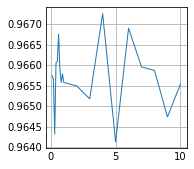

In [12]:
plt.style.use('_mpl-gallery')

# influence of p?

df_selection = results_df.loc[results_df['q'] == 1.0]
x = df_selection['p']
y = df_selection['f1 (micro)']

# make data
# x = np.linspace(0, 10, 100)
# y = 4 + 2 * np.sin(2 * x)

# plot
fig, ax = plt.subplots()
# ax = plt.plot()

ax.plot(x, y, linewidth=1.0)

# ax.set(xlim=(0, 2), xticks=np.arange(0.1, 2.0, 0.1),
#        ylim=(0, 1), yticks=np.arange(0.1, 1.0, 0.1))

plt.show()